In [ ]:
import numpy as np
import pandas as pd
import itertools
import tqdm
import pandas_gbq
from scipy import stats
import matplotlib.pyplot as plt
import db_dtypes
import seaborn as sns

# Tian & Ipeirotis Replication
- scholar's percentile rank calculated by summing the percentile rank of works published from years 0-4, 5-9, 10-14, 15-19
- 1 correlation matrix for all scholars, 1 correlation matrix separating scholars by concept

author_rank_per_yr.csv: table with authors' percentile ranking for different ranges of years, as calculated in Tian & Ipeirotis (2021)

Column Name     | Data Type | Description
----------------|-----------|------------------------
author_id       | STRING    | Unique OpenAlex ID for author
concept_0       | STRING    | 1st level 0 concept most frequently applied to author's works
start_yr        | INT       | yr of given author's 1st publication
yr_5_rank       | FLOAT     | percentile rank of given author for ages 0-4
yr_10_rank      | FLOAT     | percentile rank of given author for ages 5-9
yr_15_rank      | FLOAT     | percentile rank of given author for ages 10-14
yr_20_rank      | FLOAT     | percentile rank of given author for ages 15-19

In [ ]:
ranks = pd.read_csv("author_rank_per_yr.csv")
ranks

,author_id,concept_0,start_yr,yr_5_rank,yr_10_rank,yr_15_rank,yr_20_rank
0,https://openalex.org/A2352223159,Medicine,2006,0.000000,0.0,NaN,NaN
1,https://openalex.org/A3146124079,Medicine,2006,0.000000,0.0,NaN,NaN
2,https://openalex.org/A2356244811,Computer science,2006,0.000000,0.0,NaN,NaN
3,https://openalex.org/A2343895682,Computer science,2006,0.000000,NaN,NaN,NaN
4,https://openalex.org/A2587456635,Psychology,2006,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
19188132,https://openalex.org/A2502248108,Psychology,2000,0.000000,NaN,NaN,NaN
19188133,https://openalex.org/A2170095776,Computer science,2000,0.000000,NaN,NaN,NaN
19188134,https://openalex.org/A2193021005,Psychology,2000,0.631721,NaN,NaN,NaN
19188135,https://openalex.org/A337860639,Psychology,2000,0.000000,NaN,NaN,NaN


In [ ]:
x_cols = ["Rank from Years 1-5", "Rank from Years 6-10", "Rank from Years 11-15"][::-1]    # reordered x columns to get (yrs 1-15)  
y_cols = ["Rank from Years 6-10", "Rank from Years 11-15", "Rank from Years 16-20"]    # y columns to get (yrs 6-20)
subset = ranks[["yr_5_rank", "yr_10_rank", "yr_15_rank", "yr_20_rank"]]
subset = subset.rename(columns={"yr_5_rank":"Rank from Years 1-5", 
                  "yr_10_rank":"Rank from Years 6-10",
                  "yr_15_rank":"Rank from Years 11-15",
                  "yr_20_rank":"Rank from Years 16-20"})

corr = subset.corr()
corr
corr_subset = corr.loc[x_cols, y_cols]
corr_subset

,Rank from Years 6-10,Rank from Years 11-15,Rank from Years 16-20
Rank from Years 11-15,0.646743,1.000000,0.695024
Rank from Years 6-10,1.000000,0.646743,0.482583
Rank from Years 1-5,0.559793,0.420881,0.339899


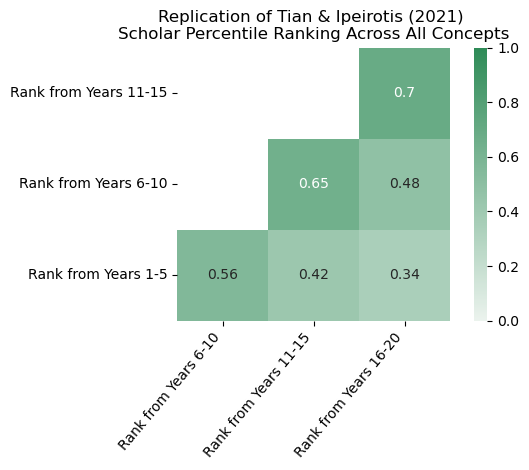

In [ ]:
color = sns.light_palette("seagreen", as_cmap=True)
mask = np.tril(np.ones_like(corr_subset, dtype=bool), k=-1)[::-1]    # mask to only show bottom right corner of matrix
ax = sns.heatmap(corr_subset, cmap = color, annot = True, mask = mask, square=True, vmin=0, vmax=1)
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='right')    # rotate x-axis labels 50 degrees (readability)  
    
# fig.set_size_inches(10, 6)  # Set the figure size (width, height)
ax.set_title("Replication of Tian & Ipeirotis (2021) \nScholar Percentile Ranking Across All Concepts")

    
plt.tight_layout()    # adds padding around elements to help things not overlap
plt.savefig('EXPORT_DEST.svg')    # export figure
plt.show()

In [ ]:
# get list of concepts

concepts = ranks["concept_0"].unique()
concepts = ['No Top Concept' if x is np.nan else x for x in concepts]
concepts.sort()
num_plots = len(concepts)
concepts

['Art',
 'Biology',
 'Business',
 'Chemistry',
 'Computer science',
 'Economics',
 'Engineering',
 'Environmental science',
 'Geography',
 'Geology',
 'History',
 'Materials science',
 'Mathematics',
 'Medicine',
 'No Top Concept',
 'Philosophy',
 'Physics',
 'Political science',
 'Psychology',
 'Sociology']

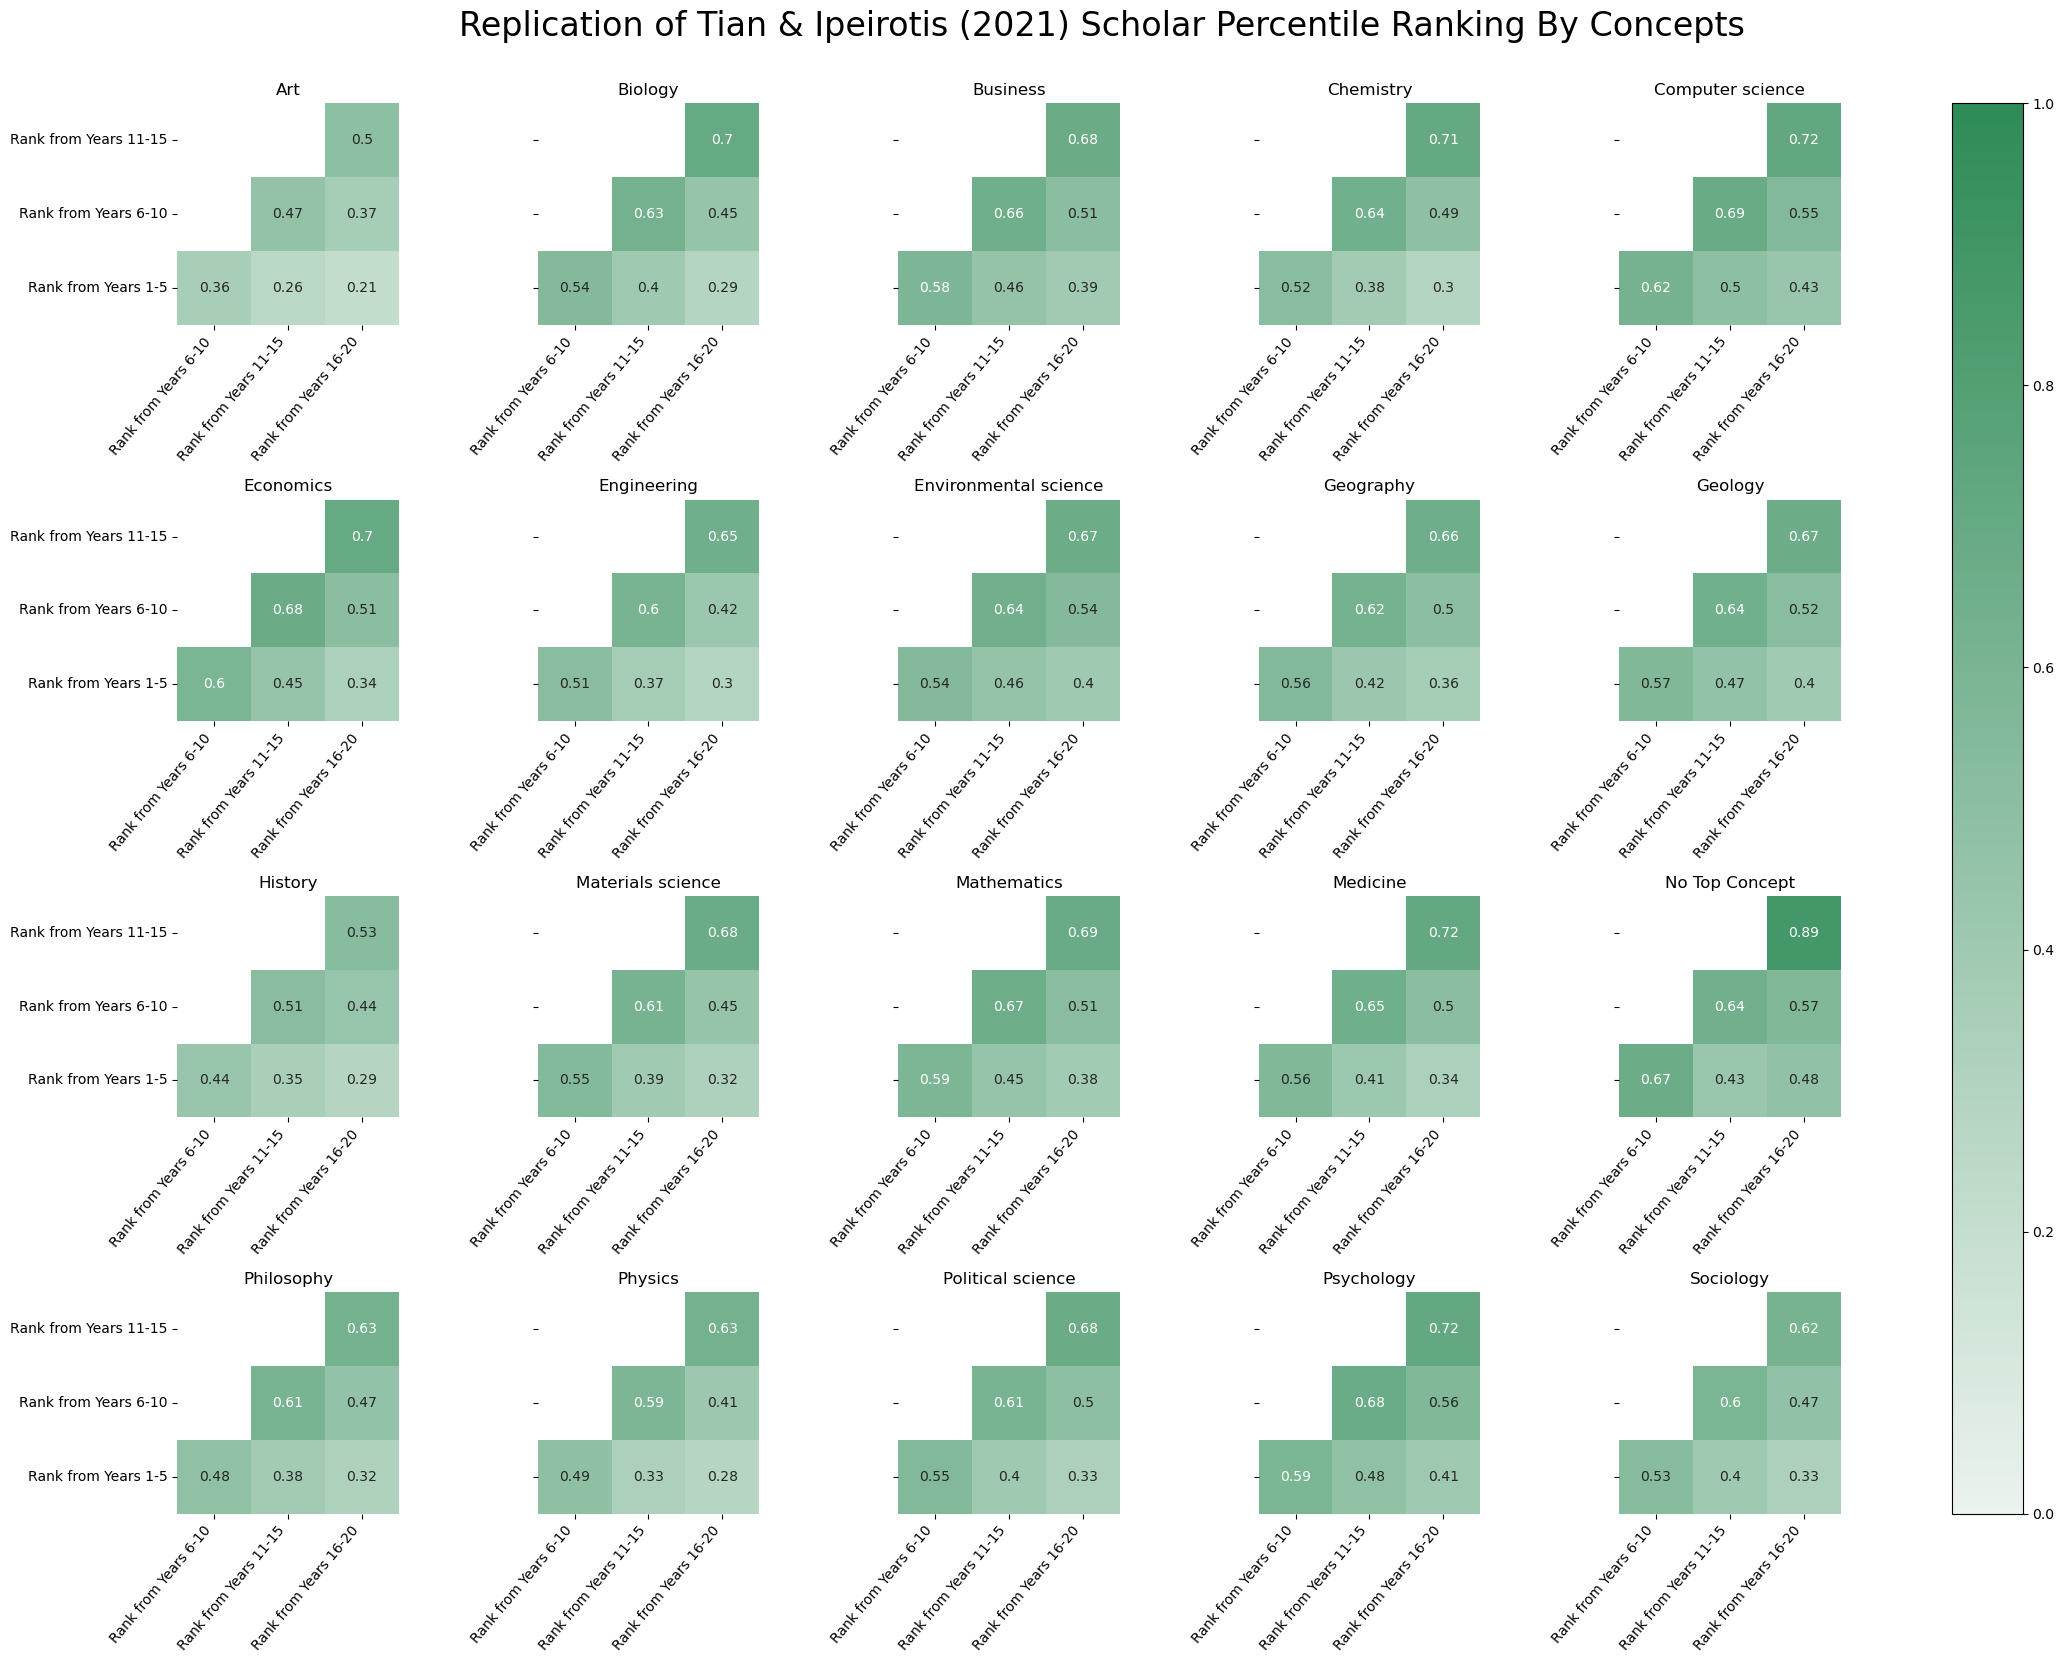

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(24,16))    # will arrange subplots on 4x5 grid

axes_flat = axes.flatten()

for i, concept in enumerate(concepts):
    # calculate correlation matrix for each concept
    if concept == "No Top Concept":
        sub = ranks[ranks["concept_0"].isnull()]
    else:
        sub = ranks[ranks["concept_0"] == concept]
    
    x_cols = ["Rank from Years 1-5", "Rank from Years 6-10", "Rank from Years 11-15"][::-1]
    y_cols = ["Rank from Years 6-10", "Rank from Years 11-15", "Rank from Years 16-20"]
    subset = sub[["yr_5_rank", "yr_10_rank", "yr_15_rank", "yr_20_rank"]]
    subset = subset.rename(columns={"yr_5_rank":"Rank from Years 1-5", 
                      "yr_10_rank":"Rank from Years 6-10",
                      "yr_15_rank":"Rank from Years 11-15",
                      "yr_20_rank":"Rank from Years 16-20"})
    corr = subset.corr()
    corr_subset = corr.loc[x_cols, y_cols]
    
    # plot each correlation matrix
    ax = axes_flat[i] if num_plots > 1 else axes
    ax.set_title(f"{concept}")
    color = sns.light_palette("seagreen", as_cmap=True)
    mask = np.tril(np.ones_like(corr_subset, dtype=bool), k=-1)[::-1]
    sns.heatmap(corr_subset, cmap=color, annot=True, mask=mask, square=True, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='right')
    
    # only show labels of y axis on left-most graphs
    if i%5 != 0:
        ax.set_yticklabels([])
    
plt.tight_layout()
fig.colorbar(axes_flat[0].collections[0], ax=axes_flat, location='right', pad=0.05)    # add single color bar for all subplots
title = "Replication of Tian & Ipeirotis (2021) Scholar Percentile Ranking By Concepts"
fig.text(0.5, 1.02, title, fontsize=24, ha="center")

plt.savefig('EXPORT_DEST.svg', bbox_inches="tight")

plt.show()